### GMM for MNIST

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
import pandas as pd
from scipy.stats import chi2, norm

In [2]:
# I am getting the data from tensorflow
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
print(mnist)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x108bfe4e0>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x108bfe748>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x108bfed68>)


In [4]:
def PCA(data, components):
    data_copy = data.copy()
    data_copy -= data_copy.mean(axis=0)
    mean_data = data_copy
    cov_matrix = np.cov(mean_data, rowvar=False)
    evals, evecs = la.eigh(cov_matrix)
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]
    evecs = evecs[:, :components]
    new_pca_data = np.dot(evecs.T, data_copy.T).T
    return new_pca_data, evecs, evals

In [6]:
data = mnist.train.images

In [7]:
new_pca_data, evecs, evals = PCA(data, 10)

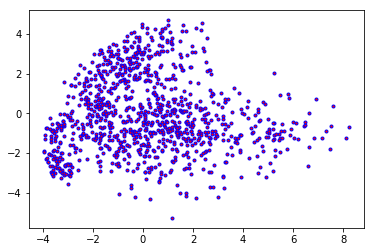

In [8]:
new_pca_data1 = new_pca_data.copy()
new_pca_data1 += new_pca_data1.mean(axis=0)
plt.plot(new_pca_data1[0:1000, 0], new_pca_data1[0:1000, 1], '.', mfc='red', mec='blue')
plt.show()

### Initializing the Gaussian Mixture Model

In [27]:
def plotGaussianModel2D(mu, sigma, pltopt='k'):
    #print(type(sigma))
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    
def colorPicker(index):
    colors = 'rgbcmyk'
    return colors[np.remainder(index, len(colors))]

def gmmplot(data, gmm):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], s=4)
    # plot Gaussian model
    color = 'rgb'
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))

In [28]:
# randomly pick coordinates as center of Gaussian distribution
def randinitMean(n, drange):
    mu = []
    for m in range(n):
        mu.append([np.random.uniform(drange[i]['MIN'], drange[i]['MAX']) for i in range(len(drange))])
    # return inf form of numpy.ndarray
    return np.asarray(mu)

In [29]:
def randinitCovariance(n):
    sigma = []
    for m in range(n):
        # randomly pick a direction
        angle = np.random.uniform(0, 2 * np.pi)
        # create eigen vector with the direction and direction orthogonal to it
        eigenVector = np.asarray([[np.cos(angle), np.sin(angle)],
                                  [np.cos(angle + np.pi/2), np.sin(angle + np.pi/2)]])
        # randomly generate eigen values
        eigenValue = abs(np.random.normal(size=2))
        # compose covariance matrix
        sigma.append(eigenVector.T.dot(np.diag(eigenValue).dot(eigenVector)))
    # return in form of numpy.ndarray
    return np.asarray(sigma)

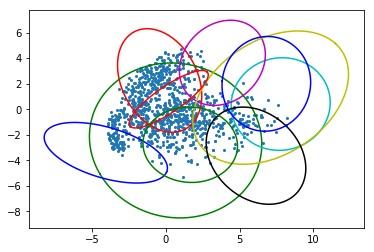

In [30]:
ngmm = 10

# get information of range on each dimension
dataRange = []
for i in range(2):
    dataRange.append({'MIN': min(new_pca_data[:,i]), 'MAX': max(new_pca_data[:,i])})
    
# randomly initialize Gaussian mixture model
mu    = randinitMean(ngmm, dataRange)
sigma = randinitCovariance(ngmm)
gmm   = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]
#print(mu.shape)
# show initial state
gmmplot(new_pca_data[0:1000,0:2], gmm)
plt.show()

In [31]:
#probability that a point came from a Gaussian with given parameters
def probability(points, parameters_dict):
    prior = parameters_dict['prior']
    mu = parameters_dict['mean']
    sigma = parameters_dict['covariance']
    #print(sigma)
    prob = prior
    for i in range(0, len(points)):
        prob *= norm.pdf(points[i], mu[i], sigma[i][i])
    return prob

In [32]:
def expectation(data, parameters):
    posterior = []
    for i in range(0, data.shape[0]):
        x = data[i][0]
        y = data[i][1]
        clusters_prob_value = []
        for j in range(0, len(parameters)):
            clusters_prob_value.append(probability([x, y], parameters[j]))
        #print(clusters_prob_value)
        clusters_prob_values = np.array(clusters_prob_value)
        #print(clusters_prob_values.argmax())
        posterior.append(clusters_prob_values.argmax())
    return posterior

In [33]:
def maximization_mean(posterior, data, parameters):
    data = pd.DataFrame(data=data)
    data['c'] = posterior
    new_parameters = parameters
    for i in range(0, len(parameters)):
        points = data[data['c'] == i]
        count_points = len(points)
        if count_points == 0:
            continue
        prior = count_points / len(data)
        mu = []
        sigma = []
        for j in range(0, data.shape[1]-1):
            mu.append(points[j].mean())
            mod_sigma = np.zeros((data.shape[1]-1))
            mod_sigma[j] = points[j].std()
            sigma.append(mod_sigma)
        sigma = np.array(sigma)
        vals_dict = {'mean':mu, 'covariance': sigma, 'prior':prior}
        parameters[i] = vals_dict
    return new_parameters

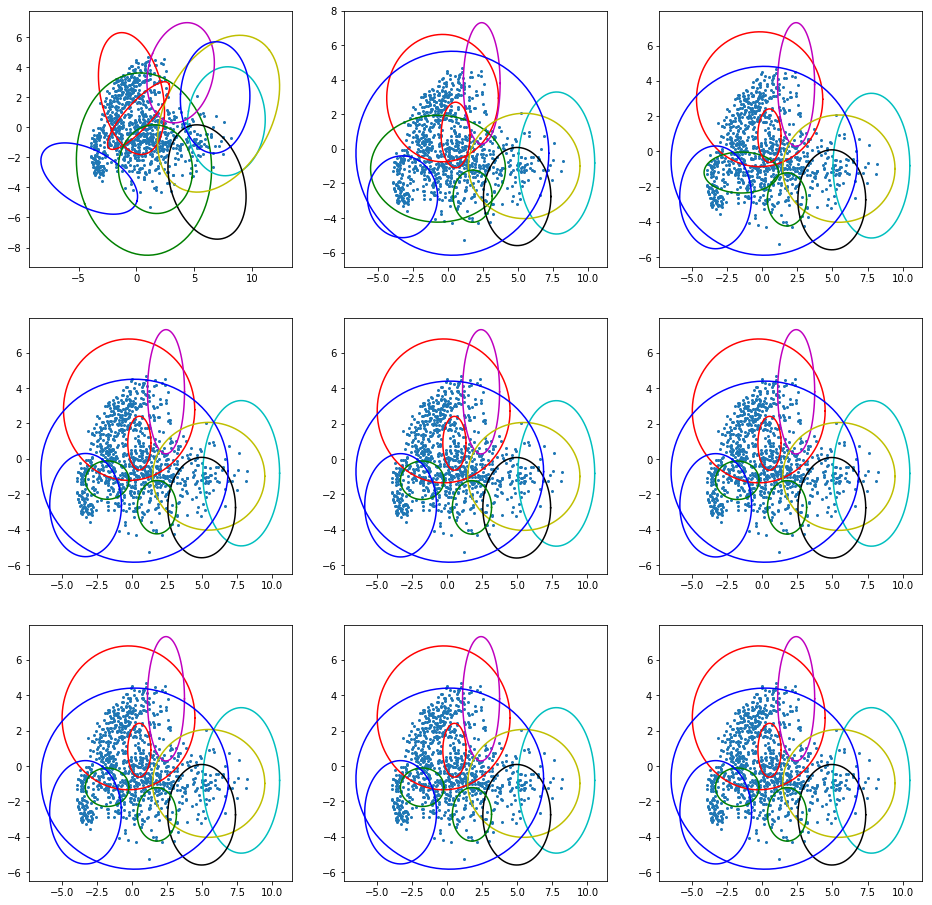

In [38]:
gmmcp = gmm.copy()

# create figure
plt.figure(figsize=(16, 16))
# improve model with EM-Algorithm
for i in range(8):
    # plot current status
    plt.subplot(331 + i)
    gmmplot(new_pca_data[0:1000, 0:2], gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(new_pca_data[0:1000, 0:2], gmmcp)
        gmmcp = maximization_mean(posterior, new_pca_data[0:1000, 0:2], gmmcp)
# plot final status
plt.subplot(339)
gmmplot(new_pca_data[0:1000, 0:2],gmmcp)
plt.show()